In [6]:
import numpy as np
import pandas as pd
import dill as pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from matplotlib import cm
import seaborn as sns
import random
import datetime
import math
from sklearn.linear_model import LinearRegression
import torch
import imageio

from FDA_Projection import FDA
from NeuralSDE import NeuralSDE

# data process

In [3]:
raw_data = pd.read_csv("G:\gitCode\BU_programming\\finnal_project\FuNVol\IV_data.csv")

C:\Users\Kishore\AppData\Local\Temp\ipykernel_4920\4073970632.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("G:\gitCode\BU_programming\\finnal_project\FuNVol\IV_data.csv")


In [4]:
raw_data = raw_data[['date', 'days', 'delta', 'impl_volatility', 'ticker']]
raw_data = raw_data.fillna(0)

In [5]:
tickers = np.unique(raw_data['ticker'])

In [6]:
def daily_IV_matrix(df:pd.DataFrame, date:pd.DatetimeTZDtype):
    return pd.pivot_table(df, values='impl_volatility', index='days', columns='delta').values
    
for ticker in tickers:

    data_by_ticker = copy.deepcopy(raw_data[raw_data['ticker']==ticker])
    data_by_ticker['date'] = pd.to_datetime(data_by_ticker['date'])
    start = data_by_ticker['date'].min()
    end = data_by_ticker['date'].max()
    data_by_ticker.sort_values(['date', 'days', 'delta'])

    price_df = pd.read_csv("G:\gitCode\BU_programming\\finnal_project\FuNVol\data\{}.csv".format(ticker))
    price_df['date'] = pd.to_datetime(price_df['Date'])
    price_df.sort_values('date', inplace=True)

    print("ticker name: {}, start time {}, end time:{}".format(ticker, start, end))
    iv_by_day = np.array([daily_IV_matrix(df, date) for date, df in data_by_ticker.groupby(['date'])])
    print("IV data shape {}".format(iv_by_day.shape))
    # iv_by_day.shape = (2893, 11, 17)
    dates = np.sort(np.array(np.unique(data_by_ticker['date'])))
    tau = np.sort(np.array(np.unique(data_by_ticker['days']))) / 365
    Delta = np.sort(np.array(np.unique(data_by_ticker['delta']))) / 100
    result_dict = {
        'dates': dates,
        'tau': tau,
        'Delta': Delta,
        'IV': iv_by_day,
        'prices': price_df['Adj Close'].values
    }
    with open("G:\gitCode\BU_programming\\finnal_project\FuNVol\data\\raw_{}.pickle".format(ticker), 'wb') as handle:
        pickle.dump(result_dict, handle)


ticker name: AMZN, start time 2010-07-08 00:00:00, end time:2021-12-31 00:00:00
IV data shape (2893, 11, 17)
ticker name: IBM, start time 2010-07-08 00:00:00, end time:2021-12-31 00:00:00
IV data shape (2893, 11, 17)
ticker name: INTC, start time 2010-07-08 00:00:00, end time:2021-12-31 00:00:00
IV data shape (2893, 11, 17)
ticker name: TSLA, start time 2010-07-08 00:00:00, end time:2021-12-31 00:00:00
IV data shape (2893, 11, 17)


# FuNVol

In [3]:
class FuNVol:
    
    def __init__(self, data_dir, tickers, K=3):
        
        # load all data
        self.raw_data = []
        self.raw_price_data = []
        self.data = []
        self.current_ticker=None
        self.tickers = np.array(tickers)
        
        latest_start_date = 0
        
        print("loading data for various tickers...")
        # load the data and normalize individually        
        for ticker in tickers:
            
            # the raw data files cannot be provided due to licensing issues
            with open(data_dir + "raw_" + ticker + '.pickle', 'rb') as handle:
                self.raw_data.append(pickle.load(handle))

        print("normalizing IVs...")
        # normalizing coefficients
        self.nrm = []
        self.reg = []
        
        for data in copy.deepcopy(self.raw_data):
            
            a_, b_, IV = self.Normalise(np.log(np.exp(data['IV'])-1))
            data['IV'] = np.where(np.isneginf(IV), np.NaN, IV)   # !!!!
            
            c_, d_, prices = self.Normalise(np.log(data['prices']))
            data['prices'] = prices

            self.nrm.append({'IV':[a_,b_], 'price' : [c_,d_]})
            self.data.append(data)
            
        print("truncating data to common set of dates...")
        # only keep data on dates where all tickers have data and
        # collate the data into a single source
        self.data_all = {'dates' : [],
                         'tau' : self.data[0]['tau'],
                         'Delta' : self.data[0]['Delta'],
                         'IV' : [],
                         'prices' : [],
                         'ticker_idx' : []}
        
        self.delta = self.data[0]['Delta']
        self.tau = self.data[0]['tau']

        for i, ticker in enumerate(tickers):
            
            # detrend the time serise data
            alpha_, beta_, prices_d = self.Detrend(self.data[i]['prices'])
            self.reg.append([alpha_,beta_])
            self.data[i]['prices'] = prices_d
            
            if i ==0 :
                self.data_all['IV'] = self.data[i]['IV']
                self.data_all['dates'] = self.data[i]['dates']
                self.data_all['ticker_idx'] = np.zeros(len(self.data[i]['dates']), int)
                self.data_all['prices'] = self.data[i]['prices']
                
            else:
                self.data_all['IV'] = np.concatenate((self.data_all['IV'], self.data[i]['IV']))
                self.data_all['dates'] = np.concatenate((self.data_all['dates'], self.data[i]['dates']))
                self.data_all['prices'] = np.concatenate((self.data_all['prices'], self.data[i]['prices']))
                self.data_all['ticker_idx'] = np.concatenate((self.data_all['ticker_idx'], i + np.zeros(len(self.data[i]['dates']), int)))
            
        self.rng_IV = np.nanquantile(self.data_all["IV"].flatten(), [0.025, 0.975])
        
        print("projecting onto functional basis...")
        self.fda_model = FDA()
        self.x = 2 * self.data_all["Delta"] - 1
        self.y = 2*np.sqrt(self.data_all["tau"])/np.max(np.sqrt(self.data_all["tau"])) - 1
        self.X, self.Y = np.meshgrid(self.x, self.y)     

        self.a = []
        self.a_all = np.zeros((0,len(self.fda_model.phi)+1))
        for data in self.data:
            self.a.append(self.Perform_Projection(data['IV']))
            self.a_all = np.concatenate((self.a_all, self.a[-1]))

        fda = FDA()
        fda.Plot_Basis()

        print("plot some sample fits...")
        idx = np.random.randint(0, self.a_all.shape[0], 5)
        self.Plot_Sample_Fits(idx, save_fig=True, save_path="image/Sample_Fits_")
        self.Plot_Sample_Fits(idx, save_fig=False)


        print("plotting time-series of coefficients")
        self.Plot_Time_Series_Coeff(self.a, savefig=True, save_path="image/Time_Series_Coeff.png")
        
        print("plotting histogram of coefficients")
        self.Plot_Histogram_Coeff(self.a, savefig=True, save_path="image/Histogram_Coeff.png")
        
        print("plot pairwise scatter")
        self.Plot_Pairwise_Scatter_Coeff(self.a, "a", savefig=True)     

        # print("Compute the common FPCs")
        mask = np.sum(np.isnan(self.a_all),axis=1)>0
        # self.fda_model.Compute_FPC_coeff(self.a_all[~mask], PlotFPC=True, savefig=True, save_path="image/fpcs.png")
        self.fda_model.Compute_FPC_coeff(self.a_all[~mask], PlotFPC=True)

        
        print("Project onto common FPCs")
        self.K = K        
        self.b = []
        self.b_all = np.zeros((0, K))
        self.b_sim = []
        self.b_price = []
        for data in self.data:
            self.b.append(self.Perform_FPC_Projection(data['IV'], K))
            self.b_all = np.concatenate((self.b_all, self.b[-1]))
            self.b_price.append(np.concatenate((self.Perform_FPC_Projection(data['IV'], K),
                                data['prices'].reshape(-1,1)), axis=1))
        
        # print("plot some sample fits...")
        # self.Plot_Sample_Fits_FPC(idx)        
        
        # print("plotting time-series of coefficients")
        # self.Plot_Time_Series_Coeff(self.b, "b", savefig=True, save_path="image/Time_Series_Coeff_FPC.png")
        
        # print("plotting histogram of coefficients")
        # self.Plot_Histogram_Coeff(self.b, "b", savefig=True, save_path="image/Histogram_Coeff_FPC.png")
        
        # print("plot pairwise scatter")
        # self.Plot_Pairwise_Scatter_Coeff(self.b, "b", savefig=True, save_path="image/param_scatter_FPC_plot.png")

    def Learn_Neural_SDE(self, ticker=None, train_percent=0.9):

        self.current_ticker = ticker
        
        N = (self.b[0].shape[1]+1)   
        M = math.floor(self.b[0].shape[0]*train_percent)
        self.train_size = M
        
        # concatenate coefficients of FDA with prices 
        if ticker is not None:
            
            ticker_idx = np.where(self.tickers == ticker)[0][0]

            data = np.concatenate((self.b[ticker_idx][:M,:N-1].reshape(-1,N-1), 
                                    self.data[ticker_idx]['prices'][:M].reshape(-1,1)), 
                                  axis=1)
            dates = pd.to_datetime(self.data[ticker_idx]['dates'][:M], format='%Y%m%d')
            T = (dates-dates[0])/ np.timedelta64(1, 'D')
            T = T.values.reshape(-1,1)/365
            
        else:
            self.current_ticker = self.tickers
            # concatenate coefficients of FDA with prices across all tickers
            for i in range(len(self.tickers)):
                if i == 0:
                    data = np.concatenate((self.b[i][:M,:N-1].reshape(-1,N-1), self.data[i]['prices'][:M].reshape(-1,1)), axis=1)
                    dates = pd.to_datetime(self.data[i]['dates'][:M], format='%Y%m%d')
                    T = (dates-dates[0])/ np.timedelta64(1, 'D')
                    T = T.values.reshape(-1,1)/365
                else:
                    data = np.concatenate((data, self.b[i][:M,:N-1].reshape(-1,N-1), self.data[i]['prices'][:M].reshape(-1,1)), axis=1)

        N = data.shape[1]
        
        params= {'normalize' : np.ones(N, bool),
                  'n_features' : N,
                  'n_GRU_layers' : 3,
                  'GRU_hidden_size' :N,
                  'nOut' : N}
        
        self.neural_sde = NeuralSDE(data, T, self.current_ticker, params)
      
    # generate IV, price and FPCCs for future scenarios
    def Generate_Data(self, nsims=1, nsteps=31):

        b_sim = self.neural_sde.Simulate_Synthetic_Time_Series(nsims=nsims, nsteps=nsteps)

        self.b_sim = b_sim 
        
        def Data_per_Ticker(b_sim, ticker_idx):
            
            price = self.Trend(*self.reg[ticker_idx], np.arange(start=self.train_size+1, 
                            stop=self.train_size+1+b_sim.shape[0], step=1).repeat(repeats=b_sim.shape[1]), b_sim[:,:,-1].reshape(-1)) 
            price = np.exp(self.UnNormalise(*self.nrm[ticker_idx]['price'], price)).reshape(b_sim.shape[0], b_sim.shape[1])
            b = b_sim[:,:,:-1]
            delta_grid_t, tau_grid_t, IV_t = self.fda_model.Generate_IV_Grid(b=b, delta = self.x, tau = self.y)
            IV = np.log(1+ np.exp(self.UnNormalise(*self.nrm[ticker_idx]['IV'], IV_t)))
            IV = IV.transpose(1,0,2,3)
            
            return delta_grid_t, tau_grid_t, IV, price
        
        if self.current_ticker is None:
            
            ticker_idx = np.where(self.tickers == self.current_ticker)[0][0]
            price = self.Trend(*self.reg[ticker_idx], np.arange(start=self.train_size+1, stop=self.train_size+1+b_sim.shape[0],
                                                        step=1).repeat(repeats=b_sim.shape[1]), b_sim[:,:, -1].reshape(-1)) 
            price = np.exp(self.UnNormalise(*self.nrm[ticker_idx]['price'], price)).reshape(b_sim.shape[0], b_sim.shape[1])
  
            b = b_sim[:,:,:-1]
            delta_grid_t, tau_grid_t, IV_t = self.fda_model.Generate_IV_Grid(b=b, delta = self.x, tau = self.y)
            IV = np.log(1+ np.exp(self.UnNormalise(*self.nrm[ticker_idx]['IV'], IV_t)))
            IV = IV.transpose(1,0,2,3)

        else:  
            
            seq_length = int(b_sim.shape[-1]/len(self.tickers))
            delta_grid_t = []
            tau_grid_t = []
            IV = []
            price = []
            for i in range(len(self.tickers)):
                delta_grid_t_i, tau_grid_t_i, IV_i, price_i = Data_per_Ticker(b_sim[:,:,i*seq_length:(i+1)*seq_length], i) 
                delta_grid_t.append(delta_grid_t_i)
                tau_grid_t.append(tau_grid_t_i)
                IV.append(IV_i)
                price.append(price_i.transpose(1,0))
            
        return delta_grid_t, tau_grid_t, IV, price, b_sim.transpose(1,0,2)

    # perform functional projection on basis functions for each day and store results         
    def Perform_Projection(self, IV):
        
        a = np.zeros((IV.shape[0], 1 + len(self.fda_model.phi)))
    
        for i, _IV in enumerate(IV):
    
            if np.sum(~np.isnan(_IV )) > 0:
                a_, a0_ = self.fda_model.Fit_IV(self.X, self.Y, _IV , PlotFit=False)
            else:
                a[i, :] = a[i-1,:]
                continue
    
            a[i, 0] = a0_
            a[i, 1:] = a_
    
            if np.mod(i + 1, 10) == 0:
                print('.', end="")
            if np.mod(i + 1, 200) == 0:
                print(' ' + str(i + 1) + ' of ' + str(IV.shape[0]))
    
        return a
        
    # perform functional projection on FPCs for each day and store results     
    def Perform_FPC_Projection(self, IV, K=5):

        b = np.zeros((IV.shape[0], K))

        for i in range(IV.shape[0]):

            if np.sum(~np.isnan(IV[i])) > 0:
                b[i, :] = self.fda_model.Fit_IV_FPC(self.X, self.Y, IV[i], K, PlotFit=False)                
            else:
                b[i, :] = b[i-1,:]
                
                continue

            if np.mod(i + 1, 10) == 0:
                print('.', end="")
            if np.mod(i + 1, 200) == 0:
                print(' ' + str(i + 1) + ' of ' + str(IV.shape[0]))
                
        return b
        
    # normalize input values
    def Normalise(self, X):
        
        qtl = np.quantile(X[~np.isnan(X[:])], [0.1, 0.9])
        
        b = 2 / (qtl[1] - qtl[0])
        a = -(qtl[1] + qtl[0])/(qtl[1] - qtl[0])
        
        return a, b, a + b * X
    
        # recover values in original scale from transformed values
    def UnNormalise(self, a, b, X):
        
        return  (X -a)/b
    
    # remove time trend from price time series
    def Detrend(self, X):
        
        t = np.arange(start=1, stop=X.shape[0]+1, step=1).reshape(-1,1)
        
        reg_model = LinearRegression()
        reg_model.fit(t, X)
        
        a0_, a_ = reg_model.intercept_, reg_model.coef_
        
        price = X - reg_model.predict(t)
        
        return a0_, a_, price
    
    # reintroduce time trend in synthetic price data
    def Trend(self, a0_, a_, t, X):
        
        price = a0_ + a_*t + X
        
        return price
    
    # plots pairwise scatter plot of FPCCs
    def Plot_Pairwise_Scatter_Coeff(self, a, title, savefig=False, save_path="image/param_scatter_plot.png"):
        
        b = [a[3], a[2], a[1], a[0]]
        a = b
        tickers = ['TSLA', 'INTC', 'IBM', 'AMZN']
        for i in range(len(a)):
            a_df = pd.DataFrame(np.vstack(a))
        
        a_df.columns = [r'$%s_{%s}$'%(title, i+1) for i in range(a[0].shape[1])]
        a_df['Asset'] = pd.Series(tickers).repeat(a[0].shape[0]).values
        
        scatter = sns.pairplot(a_df, hue='Asset', markers=["o", "^", "*", "X"], aspect=1, corner='True',plot_kws=dict(s=6, alpha=0.5))
        sns.move_legend(scatter, "upper right", bbox_to_anchor=(0.75,0.75), fontsize='30', title_fontsize='40', markerscale=3)

        for ax in scatter.axes[:,0]:
            
            ax.tick_params(axis='both', labelsize=20)
            ax.get_yaxis().set_label_coords(-0.2,0.5)
            ax.yaxis.set_major_locator(plt.MaxNLocator(3))
            label = ax.get_ylabel()
            ax.set_ylabel(label, size=30)
        
        for ax in scatter.axes[-1,:]:
            ax.tick_params(axis='both', labelsize=20)
            ax.get_xaxis().set_label_coords(0.5,-0.2)
            ax.xaxis.set_major_locator(plt.MaxNLocator(3))
            label = ax.get_xlabel()
            ax.set_xlabel(label, size=30)
            
        if savefig:    
            plt.gcf().set_size_inches(40, 35)
            plt.savefig(save_path)

    # plots histogram of FPCCs
    def Plot_Histogram_Coeff(self, a, varname="a", ncol=4, savefig=False, save_path="image/Histogram_Coeff.png"):

        m = int(np.ceil(a[0].shape[1] / ncol))

        plt.figure(figsize=(10, 10))

        for a in a:
            for i in range(a.shape[1]):
                
                plt.subplot(m, ncol, i + 1)
                plt.hist(a[:, i], bins=25, alpha=0.5)
    
                plt.title('$' + varname + '_{' + str(i) + '}$', fontsize=18)
                plt.xticks(fontsize=14)
                plt.locator_params(nbins=4)
                plt.yticks(fontsize=14)
                plt.locator_params(nbins=4)

        plt.tight_layout(pad=1.5)
        
        if savefig:
            plt.savefig(save_path)

        plt.show()

    # plots time series of FPCCs
    def Plot_Time_Series_Coeff(self, a, varname="a", ncol=4, savefig=False, save_path="image/Time_Series_Coeff.png"):
        
        m = int(np.ceil(a[0].shape[1] / ncol))
        plt.figure(figsize=(40, 20))

        for a_ in a:
            
            for i in range(a_.shape[1]):
                plt.subplot(m, ncol, i + 1)
                plt.plot(a_[:, i])
                plt.xlabel('$t$', fontsize=18)
                plt.ylabel('$' + varname + '_{' + str(i) + ',t}$', fontsize=18)
                plt.xticks(fontsize=14)
                plt.yticks(fontsize=14)
                plt.xlim(100,150)

        plt.tight_layout()
        
        if savefig:
            plt.savefig(save_path)    

        plt.show()
    
    # plot samples of fitted surfaces using basis functions
    def Plot_Sample_Fits(self, idx, save_fig=False, save_path="image/Sample_Fits_"):
    
        count = 1
        for m in range(len(idx)):
            X_fit, Y_fit, Z_fit = self.fda_model.Generate_Surface(self.a_all[idx[m], 0], self.a_all[idx[m], 1:])
    
            fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
            ax.plot_surface(X_fit, Y_fit, Z_fit, linewidth=0, antialiased=True, alpha=0.7)
            ax.scatter(self.X.flatten(), self.Y.flatten(), self.data_all["IV"][idx[m]].flatten(), color='r')
            # ax.set_zlim(self.rng_IV)
            ax.set_xlabel(r"$\widetilde{\Delta}$")
            ax.set_ylabel(r"$\widetilde{\tau}$")
            ax.set_zlabel(r"$\widetilde{\sigma}$")
            ax.set_title(idx[m])
            
            if save_fig:
                fig.savefig(save_path + str(count) + ".png")
                
            count += 1
            
            print(count)
    
    # plot samples of fitted surfaces using FPCs       
    def Plot_Sample_Fits_FPC(self, idx):

        for m in range(len(idx)):
            X_fit, Y_fit, Z_fit = self.fda_model.Generate_Surface(self.a_all[idx[m], 0], self.a_all[idx[m], 1:])
            X_fit_FPC, Y_fit_FPC, Z_fit_FPC = self.fda_model.Generate_FPC_Surface(self.b_all[idx[m], :])

            fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
            ax.plot_surface(X_fit, Y_fit, Z_fit, linewidth=0, antialiased=True, alpha=0.7)
            ax.plot_surface(X_fit_FPC, Y_fit_FPC, Z_fit_FPC, linewidth=0, antialiased=True, alpha=0.7)
            ax.scatter(self.X.flatten(), self.Y.flatten(), self.data_all["IV"][idx[m]].flatten(), color='r')
            ax.set_xlabel(r"$\widetilde{\Delta}$")
            ax.set_ylabel(r"$\widetilde{\tau}$")
            ax.set_zlabel(r"$\widetilde{\sigma}$")
            ax.set_title(idx[m])

            plt.show()

In [4]:
from pycallgraph2 import PyCallGraph
from pycallgraph2.output import GraphvizOutput
from pycallgraph2 import Config
from pycallgraph2 import GlobbingFilter


loading data for various tickers...
normalizing IVs...


C:\Users\Kishore\AppData\Local\Temp\ipykernel_16916\2997736303.py:29: RuntimeWarning: divide by zero encountered in log
  a_, b_, IV = self.Normalise(np.log(np.exp(data['IV'])-1))


truncating data to common set of dates...
projecting onto functional basis...
.................... 200 of 2893
.................... 400 of 2893
.................... 600 of 2893
.................... 800 of 2893
.................... 1000 of 2893
.................... 1200 of 2893
.................... 1400 of 2893
.................... 1600 of 2893
.................... 1800 of 2893
.................... 2000 of 2893
.................... 2200 of 2893
.................... 2400 of 2893
.................... 2600 of 2893
.................... 2800 of 2893
............................. 200 of 2893
.................... 400 of 2893
.................... 600 of 2893
.................... 800 of 2893
.................... 1000 of 2893
.................... 1200 of 2893
.................... 1400 of 2893
.................... 1600 of 2893
.................... 1800 of 2893
.................... 2000 of 2893
.................... 2200 of 2893
.................... 2400 of 2893
.................... 2600 of 2893
...

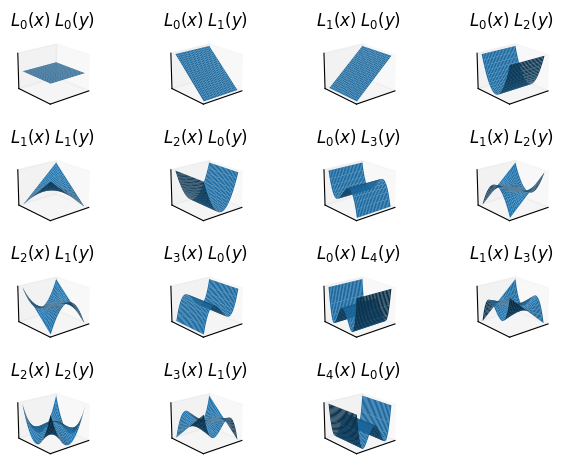

c:\Users\Kishore\anaconda3\envs\pytorch\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


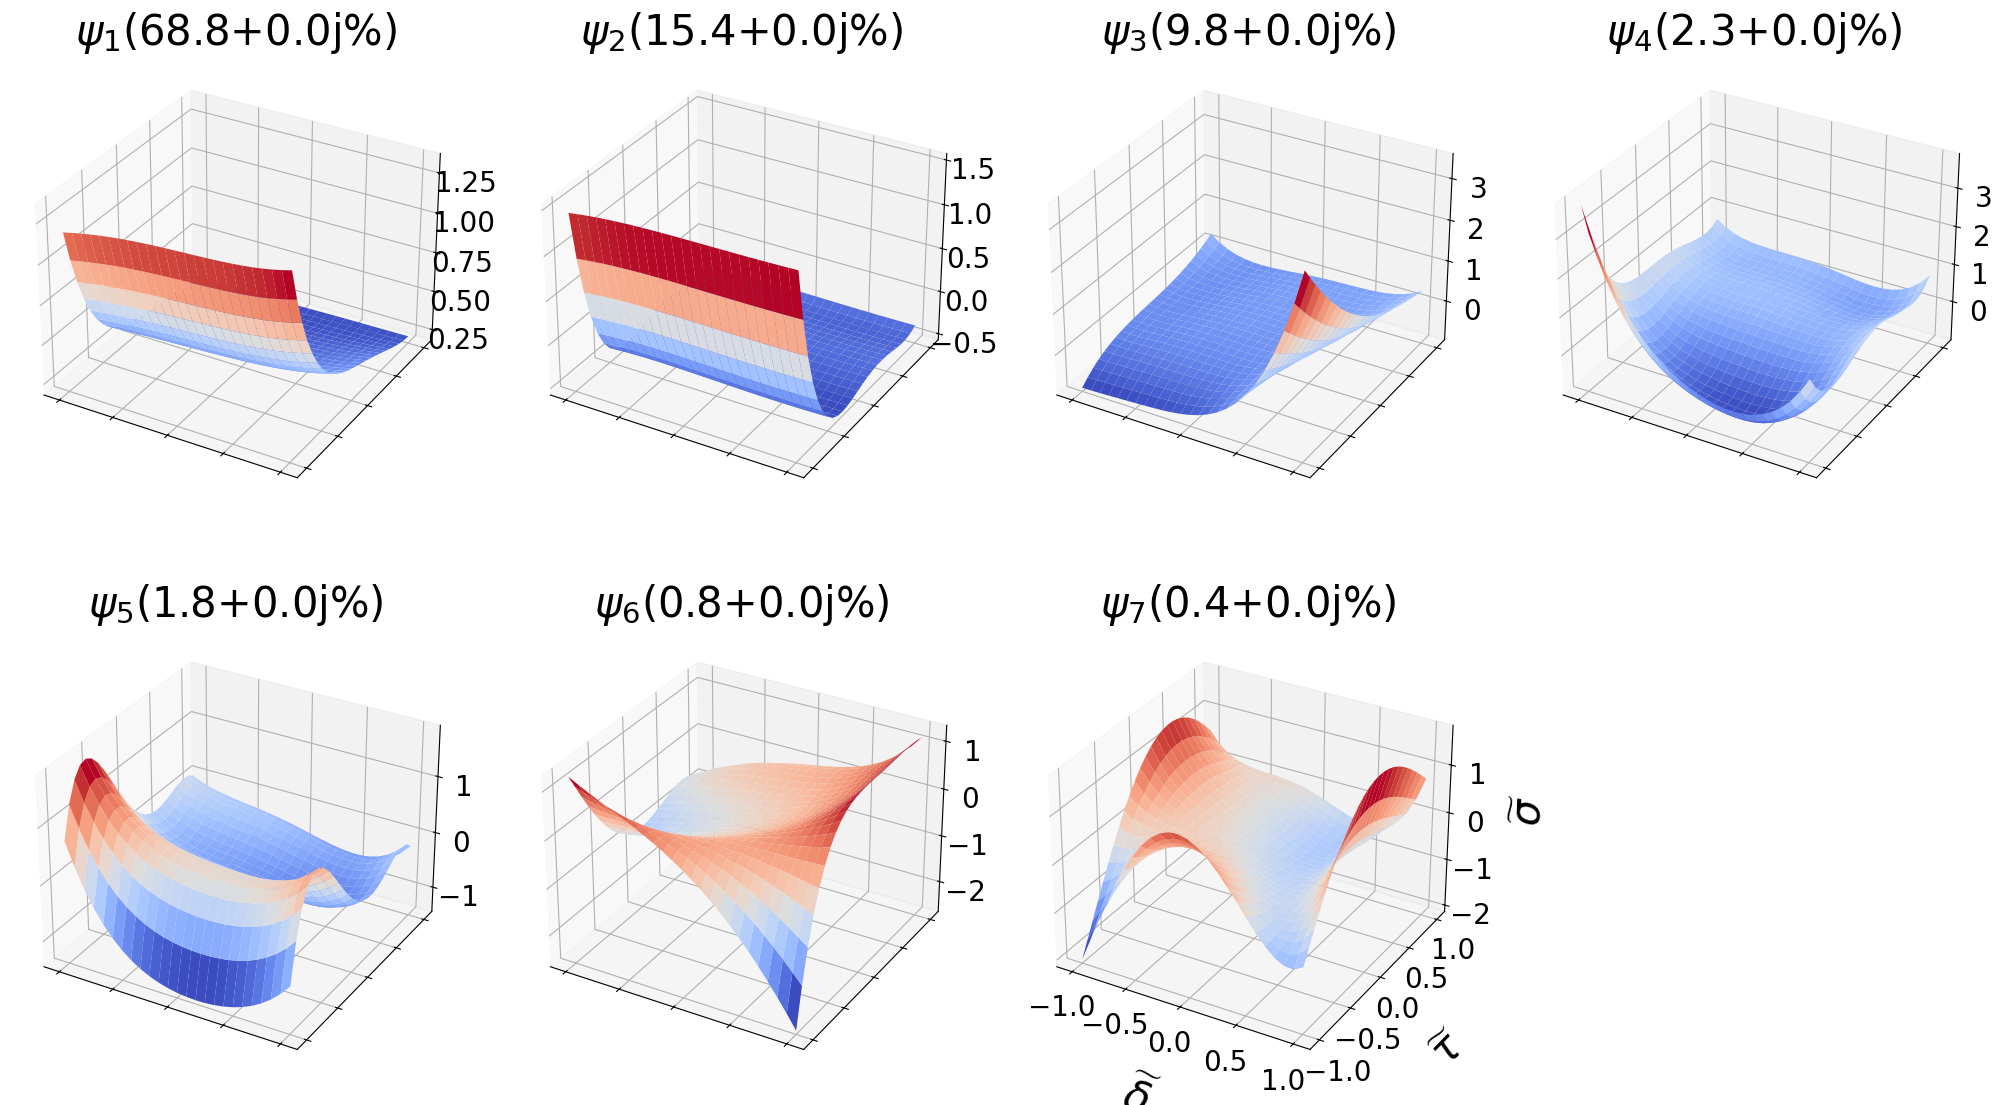

Project onto common FPCs
.................... 200 of 2893
.................... 400 of 2893
.................... 600 of 2893
.................... 800 of 2893
.................... 1000 of 2893
.................... 1200 of 2893
.................... 1400 of 2893
.................... 1600 of 2893
.................... 1800 of 2893
.................... 2000 of 2893
.................... 2200 of 2893
.................... 2400 of 2893
.................... 2600 of 2893
.................... 2800 of 2893
............................. 200 of 2893
.................... 400 of 2893
.................... 600 of 2893
.................... 800 of 2893
.................... 1000 of 2893
.................... 1200 of 2893
.................... 1400 of 2893
.................... 1600 of 2893
.................... 1800 of 2893
.................... 2000 of 2893
.................... 2200 of 2893
.................... 2400 of 2893
.................... 2600 of 2893
.................... 2800 of 2893
......................

TypeError: unhashable type: 'ModuleSpec'

In [8]:
# # perform FPC projection
# model= FuNVol('./data/', ['AMZN', 'IBM'], K=8)
def main():
    model = FuNVol('./data/', ['AMZN', 'IBM'], K=8)
    model.Learn_Neural_SDE()
if __name__ == "__main__":
    config = Config()

    graphviz = GraphvizOutput()
    graphviz.output_file = 'graph.png'
    with PyCallGraph(output=graphviz, config=config):
        main()


# Model Training

In [10]:
# learn the neural SDE model for time series of FPCCs and prices
# model.Learn_Neural_SDE(ticker='IBM')
model.Learn_Neural_SDE()

In [14]:
a = np.array([[0.09, 0.03],
              [0.03, 0.25]])
b = np.array([[0.05], [0.15]])

a_ivs = np.linalg.inv(a)

c = np.array([1, 1])

1- np.dot((9.1 * np.dot(a_ivs, b) / (np.dot(c, np.dot(a_ivs, b)))).T, c.T)


array([-8.1])

In [11]:
d = np.array([0.05, 0.15])
(np.dot(c, np.dot(a_ivs, b))) / (np.dot(d, np.dot(a_ivs, b)))

array([9.09090909])

In [ ]:
# minimize MSE in stage 1
for i in range(2):
    
    now = datetime.datetime.now()
    print(i, str(now))
     
    model.neural_sde.Train(n_iter=10, LOSS='MSE') 
    # model.neural_sde.Plot_Band()
    # model.neural_sde.Plot_Band(M=2593)
    model.neural_sde.Plot_Loss()
    # model.neural_sde.Plot_PIT()

    # load saved model with least MSE
with open('data/least_MSE.pkl', 'rb') as inp:
    model.neural_sde = pickle.load(inp)
        
# minimize penalized negative log-likelihood by fixing the drift neural network in stage 2
for i in range(2):
    
    now = datetime.datetime.now()
    print(i, str(now))
     
    model.neural_sde.Train(n_iter=10, LOSS='LL_diffusion') 
    # model.neural_sde.Plot_Band()
    # model.neural_sde.Plot_Band(M=2593)
    model.neural_sde.Plot_Loss()
    # model.neural_sde.Plot_PIT()

# load saved model with least penalized negative log-likelihood at end of stage 2
with open('data/least_penalized_LL_diffusion.pkl', 'rb') as inp:
    model.neural_sde = pickle.load(inp)

# minimize penalized negative log-likelihood by learning both the drift and diffusion neural networks in stage 3    
for i in range(2):
    
    now = datetime.datetime.now()
    print(i, str(now))
     
    model.neural_sde.Train(n_iter=2, LOSS='LL_combined') 
    # model.neural_sde.Plot_Band()
    # model.neural_sde.Plot_Band(M=2593)
    # model.neural_sde.Plot_Loss()
    # model.neural_sde.Plot_PIT()

# load saved model with least penalized negative log-likelihood at end of stage 3 to be used as final learnt model
with open('data/least_penalized_LL_combined.pkl', 'rb') as inp:
    model.neural_sde = pickle.load(inp)

with open('data/dynamicIV.pkl', 'wb') as outp:
    pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)   

In [ ]:
# minimize MSE in stage 1
for i in range(70):
    
    now = datetime.datetime.now()
    print(i, str(now))
     
    model.neural_sde.Train(n_iter=10_000, LOSS='MSE') 
    # model.neural_sde.Plot_Band()
    # model.neural_sde.Plot_Band(M=2593)
    model.neural_sde.Plot_Loss()
    # model.neural_sde.Plot_PIT()

    # load saved model with least MSE
with open('data/least_MSE.pkl', 'rb') as inp:
    model.neural_sde = pickle.load(inp)
        
# minimize penalized negative log-likelihood by fixing the drift neural network in stage 2
for i in range(20):
    
    now = datetime.datetime.now()
    print(i, str(now))
     
    model.neural_sde.Train(n_iter=10_000, LOSS='LL_diffusion') 
    # model.neural_sde.Plot_Band()
    # model.neural_sde.Plot_Band(M=2593)
    model.neural_sde.Plot_Loss()
    # model.neural_sde.Plot_PIT()

# load saved model with least penalized negative log-likelihood at end of stage 2
with open('data/least_penalized_LL_diffusion.pkl', 'rb') as inp:
    model.neural_sde = pickle.load(inp)

# minimize penalized negative log-likelihood by learning both the drift and diffusion neural networks in stage 3    
for i in range(20):
    
    now = datetime.datetime.now()
    print(i, str(now))
     
    model.neural_sde.Train(n_iter=10_000, LOSS='LL_combined') 
    model.neural_sde.Plot_Band()
    model.neural_sde.Plot_Band(M=2593)
    model.neural_sde.Plot_Loss()
    model.neural_sde.Plot_PIT()

# load saved model with least penalized negative log-likelihood at end of stage 3 to be used as final learnt model
with open('data/least_penalized_LL_combined.pkl', 'rb') as inp:
    model.neural_sde = pickle.load(inp)

with open('data/dynamicIV.pkl', 'wb') as outp:
    pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)   
    

In [16]:
model.current_ticker

array(['AMZN', 'IBM'], dtype='<U4')

In [17]:
#%%
# Generate data for future scenarios
# Can provide the number of independent scenarios and time steps as arguments to the function

with torch.no_grad():
    delta_grid_t, tau_grid_t, IV, price, b_sim = model.Generate_Data(nsims=10, nsteps=31)
    
""" delta_grid_t and tau_grid_t are lists containing the transformed delta-tau meshgrid for each equity
By default, IV values are calculated on the same grid as that for which data was available
IV is a list containing the implied vol values on the above grid for each equity
price is a list containing price paths for each equity
b_sim contains the simulated time series of FPCCs and equity prices """

""" b_sim is nsims x nsteps x 36 (4 equities times 8 FPCCs plus 1 price) dimensional
The first index corresponds to the generated (independent) scenarios
The second index corresponds to the sequence of days where day 0 is the last day of training (observed) and the remaining 29 days are generated coefficients
Hence day 0 will give the FPC coefficients (FPCCs) for the IV surface that is observed on the last day of training and is not a synthetic generated surface
The last index corresponds to the different assets' FPCCs and transformed equity prices, details for third index below:
0-7 give FPCCs for AMZN, 8 gives transformed equity price for AMZN
9-16 give FPCCs for IBM, 17 gives transformed equity price for IBM
18-25 give FPCCs for INTC, 26 gives transformed equity price for INTC
27-34 give FPCCs for TSLA, 35 gives transformed equity price for TSLA """

""" Each element of price is nsims x nsteps dimensional """

"""Each element in the list IV is nsims x nsteps x len(tau) x len(delta) dimensional
Each element of delta_grid_t and tau_grid_t is len(tau) x len(delta) containing the transformed
values of delta and tau on a grid at which IV is calculated"""

# to plot surfaces and get IV values at a different grid, refer to generated_data.ipynb
with open('data/sim_data_coeffs.npy', 'wb') as f:
    np.save(f, b_sim)
    
with open('data/sim_data_prices.npy', 'wb') as f:
    np.save(f, np.array(price).transpose(1,2,0))

In [13]:
state_dict = model.neural_sde.pi_diffusion.gru_diffusion.state_dict()

# Print the keys and corresponding shapes of the parameters
for key, value in state_dict.items():
    print(f"Parameter: {key}, Shape: {value.shape}")


Parameter: weight_ih_l0, Shape: torch.Size([27, 9])
Parameter: weight_hh_l0, Shape: torch.Size([27, 9])
Parameter: bias_ih_l0, Shape: torch.Size([27])
Parameter: bias_hh_l0, Shape: torch.Size([27])
Parameter: weight_ih_l1, Shape: torch.Size([27, 9])
Parameter: weight_hh_l1, Shape: torch.Size([27, 9])
Parameter: bias_ih_l1, Shape: torch.Size([27])
Parameter: bias_hh_l1, Shape: torch.Size([27])
Parameter: weight_ih_l2, Shape: torch.Size([27, 9])
Parameter: weight_hh_l2, Shape: torch.Size([27, 9])
Parameter: bias_ih_l2, Shape: torch.Size([27])
Parameter: bias_hh_l2, Shape: torch.Size([27])
